**Project context** <br>This notebook is part of the project "Bookmakerspy", a project that aims at predicting football games results in the context of the English Premier League (based on data from 2014 to 2018) and ultimately beat bookmakers' odds.<br>
The current notebook "bookmakerspy_betting_strategy" is the fourth in a series of 4 notebooks.
**Notebook goal**<br>
This Notebook aims at proposing a betting strategy and its gain curve is plotted in order to quantify the benefits of using machine learning model for sport bets

In the previous section, different reduction methodologies and classification models have been test and compared with bookmaker's predictions. The selected model computes the probalbility of the predicted event. Based on this result, it is now possible to test different betting strategies in order to quantify the benefits of our approach.

The betting strategy should answer the following questions:

1/ When should I bet ?

2/ How much should I bet ?


1- To answer the first point we can simply consider the following decision ratio: 

R = Computed probability of the event / Probability of the event according to the bookmakers

The probability of the event can be deduced from the mean of all bookmaker' odds for the event predicted:

R = p(event)*Sum_i(odd_i(event))/(Number of Bookmakers)  i from 1 to Number of bookmakers

If R>alpha, alpha>1 we can bet. Different values of alpha will be tested to tune this threshold.


2- The Kelly Criterion:

The Kelly criterion is a formula that determines the optimal theoretical amount of money for a bet/investment. It is found by by maximizing the expected value of the logarithm of wealth (see https://en.wikipedia.org/wiki/Kelly_criterion).

f = p-(q/b)

- f is the fraction of the available money to bet (in %)
- b is the net fractional odds; (For instance, if 'o' is the odd, b=o-1)
- p is the computed probability of a win
- q=1-p is the computed probability of a loss

Limits:

It is valid when the expected returns are known. It is designed for long term runs (infinite number of bets).
There exists more general a formula or a formula adapted for multiple bets on the same game but this basic version will first be tested for our specific problem. In practice, it is recomanded to use a fraction of f, that is beta.f where beta<1 and needs to be tune.

In this section we will focus on testing two different types of decision criteria:

- The decision ratio R previously introduced
- A probability threshold: if the probability computed is above the threshold it is decided to bet

For each decision criteria oen considers three different approaches to fix the bet amount:

- A fixed bet amount arbitrarily chosen
- A fixed proportion of the account balanced arbitrarily chosen
- An optimized proportion of the account balance: the Kelly criterion

By plotting the cumulative gain as a function of the number of games we bet on, all the parameters introduced will be tuned in order to look for the optimal betting strategy:

- Variation of the ratio R (that is: tunning the parameter alpha previously introduced).
- Variation of the probability threshold.
- Variation of the Kelly Criterion (that is: tunning the parameter beta).
- Variation of the fixed bet amount
- Variation of the fixed proportion of the account balanced


Finally, we will compare these results obtained with prediction models with approaches that don't require machine learning tools. The decision criteran is based on bookmakers'odds only:

- 'Sure Bets'. A practice where the player bets on all possible outcomes of a game. This practice leads to loosing money if all bets are made with a particular bookmaker, but combining all bookmakers odds and for particular amounts of money it can be checked that the wining bet gain is higher than the money lost by the two other bets. In these particular conditions, the bet is considered as 'sure' and the gain is guaranteed. The limits of this approach will also be discussed.
- Bookmaker mistakes: If a bookmaker odd is far enough from the mean of all bookmakers' odds then we bet on the match.

## 1. Pre-processing

In [ ]:
# Probability matrix, shape and meaning
# probs = vclf_FS.predict_proba(X_test_FS)
probs = grid_xgb_R.predict_proba(X_test_R)

pred = y_pred_u_xgb_R

In [ ]:
# This can be compared with the model prediction. it can be deduced that:
# First columns is the probability of event A
# Second columns is the probability of event D
# Third columns is the probability of event H
y_pred_u_xgb_R[0:5]

array(['A', 'H', 'H', 'H', 'H'], dtype=object)

In [ ]:
# A new dataframe df_bet is created by considering only the matchs we will bet on (last season)
#df_bet  = df[df['season']=='2017_2018']
df_bet  = df.loc[y_test.index,:]

# Predictions and probabilities computed are added to this dataset
df_bet['Match_Prediction'] = pred

df_bet['Proba_A'] = probs[:,0]
df_bet['Proba_D'] = probs[:,1]
df_bet['Proba_H'] = probs[:,2]

# The probability of the event predicted is also added 
# that is the maximum of the probability of each class named Proba_A, Proba_D, Proba_H
df_bet['Match_Prediction_proba'] = np.max(probs, axis=1)

In [ ]:
# !!! Warning, the bookmaker margin has to be taken into account when computing the probability of the event.
# p(A)+p(D)+p(H) = 1 + epsilon, it is always strictly above 1, epsilon > 0
# Thus: p(A) is replaced by p(A)/(1+epsilon), etc.

# Probability of the event according to bookmakers:
def bookmaker_proba(pred_result, df):
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    prob = []
    for i in range(len(df)):
        prob_book   = []
        for j in bookmaker_list:
            # For each bookmaker,one computes their margin to reajust the wining probability
            odd_A = df.iloc[i, df.columns.get_loc(j+'A')]
            odd_D = df.iloc[i, df.columns.get_loc(j+'D')]
            odd_H = df.iloc[i, df.columns.get_loc(j+'H')]
            margin_book = 1/odd_A + 1/odd_D + 1/odd_H        
            #For each bookmaker, one extract the probability of the predicted event (named p). p = (1/odd)*(1/margin)
            index_col = df.columns.get_loc(j+pred_result.iloc[i])
            p = 1/df.iloc[i, index_col]/margin_book
            prob_book.append(p)
            
        prob.append(np.mean(prob_book))
        # Prob is the mean of normalized bookmaker probabilities. 
        # It is the probability of the predicted event according to the bookmakers.
    return prob

In [ ]:
# The probability of the event is added to the dataframe, the columns 'Bookmaker_probability' is created
df_bet['Bookmaker_probability_prediction'] = bookmaker_proba(df_bet['Match_Prediction'], df_bet)

In [ ]:
# Comparison between the probability considered by the bookmaker of the predicted event to happen,
# and the probability computed for the predicted event
df_bet[['Bookmaker_probability_prediction', 'Match_Prediction_proba']].head(20)

,Bookmaker_probability_prediction,Match_Prediction_proba
match_id,,
1190190,0.524654,0.381419
1190206,0.085995,0.435023
1190459,0.559673,0.353513
1190209,0.459860,0.407633
1190189,0.734792,0.442196
1190197,0.726293,0.420083
1190199,0.418307,0.373612
1190215,0.741167,0.382823
1190221,0.486996,0.353513


In [ ]:
# Column that indicates if the prediction is good or not (logical)
df_bet['Winning_bet'] = (df_bet['Match_Prediction'] == df_bet['FTR'])

In [ ]:
# Column that gives the best bookmaker for betting: Maximum of all odds of the predicted event
def best_odd(pred_result, df):
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    best_odd = []
    for i in range(len(df)):
        odds   = []
        for j in bookmaker_list:
            #For each bookmaker, one extract the odd of the predicted event
            index_col = df.columns.get_loc(j+pred_result.iloc[i])
            o = df.iloc[i, index_col]
            odds.append(o)
        best_odd.append(np.max(odds))

    return best_odd

In [ ]:
df_bet['Best_odd'] = best_odd(df_bet['Match_Prediction'], df_bet)

In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R
# - Computes the optimum amount one should bet by applying the Kelly criterion. 
#   f is the fraction considered of the Kelly criteron f is in 0 and 1
# - Computes from the game result the account balance
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Kelly(R, f, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)

    for i in range(len(prob_computed)):
       # if (prob_computed.iloc[i]/prob_bookmaker.iloc[i]>R): # Test of a different decision ratio
        if (prob_computed.iloc[i]*odds.iloc[i]>R): # Check for the decision ratio    
            Kelly = (prob_computed.iloc[i]*odds.iloc[i]-1)/(odds.iloc[i]-1)
            if Kelly>limit:
                Kelly=limit
            if Kelly<0.0:
                Kelly=0.0    
            bet = gain[-1]*Kelly*f
            
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*odd is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match
    

In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R
# - Computes from the game result and a fixed amount of money the account balance
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Fixed(R, fixed, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
       # if (prob_computed.iloc[i]/prob_bookmaker.iloc[i]>R):# Test of a different decision ratio
        if (prob_computed.iloc[i]*odds.iloc[i]>R): # Check for the decision ratio  
            Kelly = prob_computed.iloc[i] + (prob_computed.iloc[i]-1)/(odds.iloc[i]-1)
            bet = fixed
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*(odd-1) is added to the account balance
            else:
                g = gain[-1] - bet                  # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match

In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by computing the decision ratio R
# - Computes from the game result and a fixed proportion of the account balance
#   Output: the account balance evolution after each bet (gain), the match ids of bets

def betting_workflow_R_Fixed_Proportion(R, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
       # if (prob_computed.iloc[i]/prob_bookmaker.iloc[i]>R): # Test of a different decision ratio
        if (prob_computed.iloc[i]*odds.iloc[i]>R): # Check for the decision ratio  
            Kelly = prob_computed.iloc[i] + (prob_computed.iloc[i]-1)/(odds.iloc[i]-1)
            bet = gain[-1]*fixed_prop
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*odd is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match

In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes the optimum amount one should bet by applying the Kelly criterion (if the option is activated Kelly=1 and 0 if not)
# - Computes from the game result the account balance

def betting_workflow_Threshold_Kelly(threshold, f, limit, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            Kelly = (prob_computed.iloc[i]*odds.iloc[i]-1)/(odds.iloc[i]-1)
            if Kelly>limit:
                Kelly=limit
            if Kelly<0.0:
                Kelly=0.0    
            bet = gain[-1]*Kelly*f
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*odd is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match 


In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes from the game result and a fixed amount of money the account balance

def betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            bet = fixed
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*odd is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match     

In [ ]:
# For each game, the function hereunder:
# - Checks if one should bet on the game by comparing the computed probability with a threshold 
# - Computes from the game result and a fixed proportion of the account balance

def betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    for i in range(len(prob_computed)):
        if (prob_computed.iloc[i]>threshold): # Check for the decision ratio
            bet = gain[-1]*fixed_prop
            if winning.iloc[i]:
                g = gain[-1] + bet*(odds.iloc[i]-1) # If one wins, bet*odd is added to the account balance
            else:
                g = gain[-1] - bet              # If one loses, the bet is substracted to the account balance
            gain.append(g)    
            match.append(match_id[i])
    return gain , match 

## 2. Parameters selection of the betting strategy using the prediction model

### 2.1 Influence of the decision ratio R

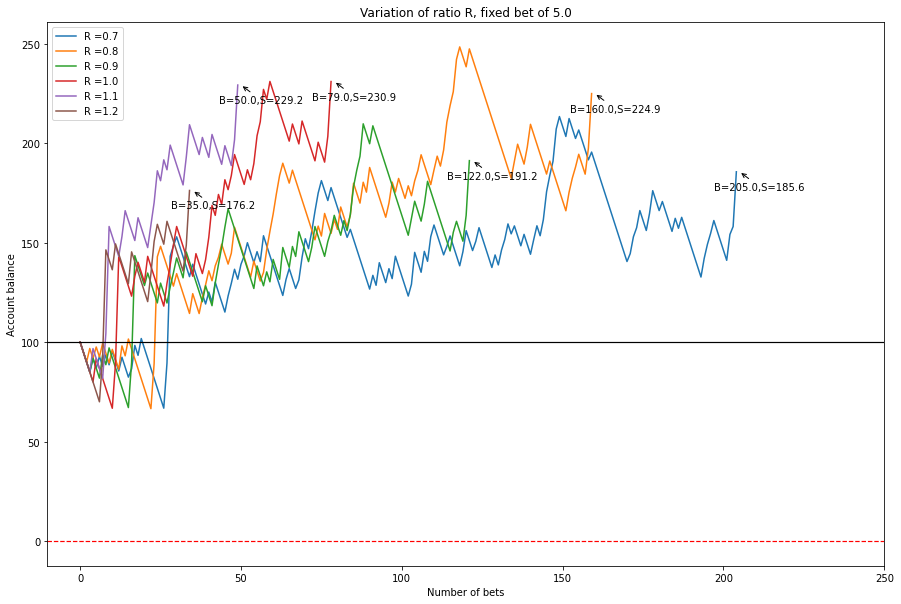

In [ ]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)

# Initial balance: 100
# Fixed bet: 5
# Values considered for R in variable param_var

param_var = [0.7, 0.8, 0.9, 1, 1.1, 1.2]
fixed_bet = 5
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Fixed(R, fixed, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed(i , fixed_bet, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("B={0:.1f},S={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,260,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, fixed bet of {:.1f}'.format(fixed_bet))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# No clear tendancy.Optimum around 1.1

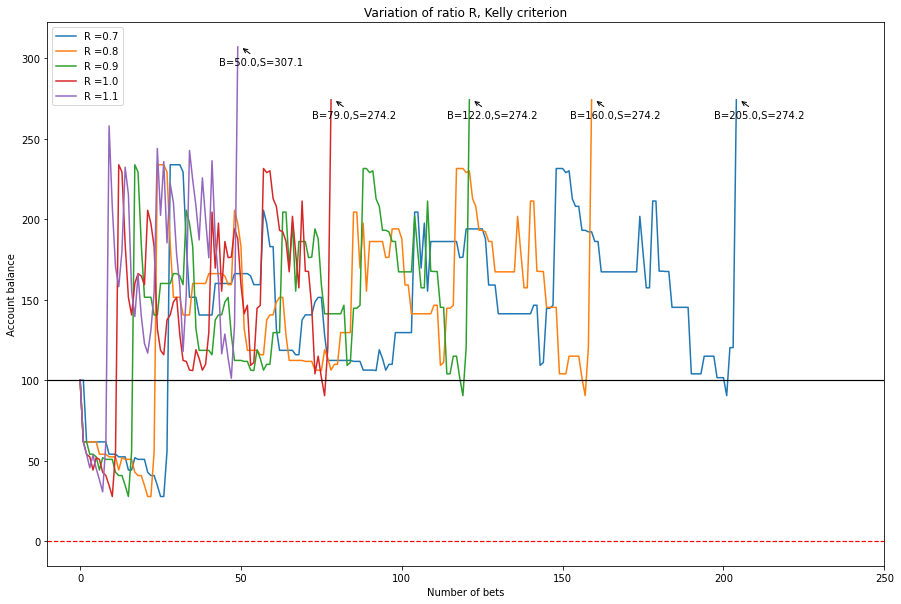

In [ ]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)

# Initial balance: 100
# Kelly criterion
# Values considered for R in variable param_var

param_var = [0.7, 0.8, 0.9, 1, 1.1]
f = 1        # % of the Kelly criterion considered
limit = 1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, f, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(i , f, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("B={0:.1f},S={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,260,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, Kelly criterion')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# for R<1, the same result (kelly criterion is 0 if R<1)
# Results are not satistying as the bankroll is always decreasing

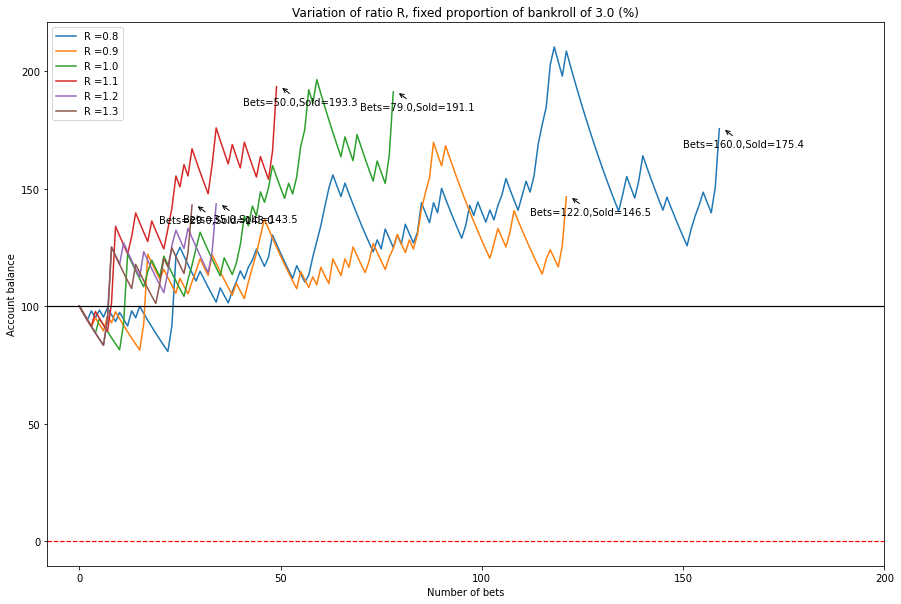

In [ ]:
# Influence of the decision ratio R (One considers all the matches in the Test dataset)

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for R in variable param_var

param_var = [0.8, 0.9, 1, 1.1, 1.2, 1.3]
fixed_prop = 0.03        # Fixed % of the bankroll for betting
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # betting_workflow_R_Fixed_Proportion(R, fixed_prop, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed_Proportion(i , fixed_prop, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="R ={:.1f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,210,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of ratio R, fixed proportion of bankroll of {:.1f} (%)'.format(fixed_prop*100))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# Less efficient that a fixed bet
# Optimum around 1.1

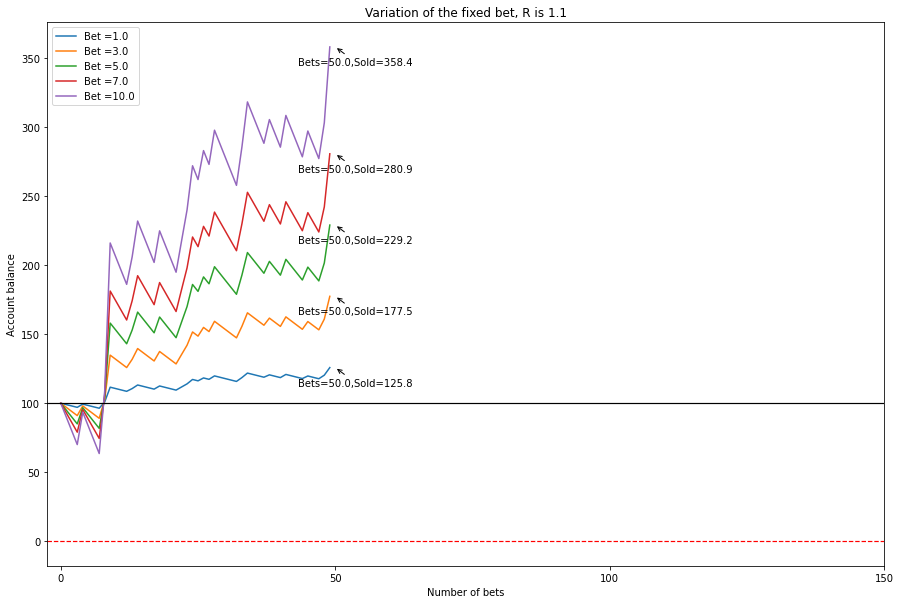

In [ ]:
# Influence of the fixed bet (One considers all the matches in the Test dataset)

# Initial balance: 100
# R = 1.1
# Values considered for fixed bet in variable param_var

param_var = [1, 3, 5, 7, 10]
R = 1.1
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Fixed(R, fixed, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed(R , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Bet ={:.1f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet, R is {:.1f}'.format(R))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# The curve shape is always the same and an homothetic relation exist between curves
# The highest fixed bet amount ends up with the highest profit (end the biggest loss)

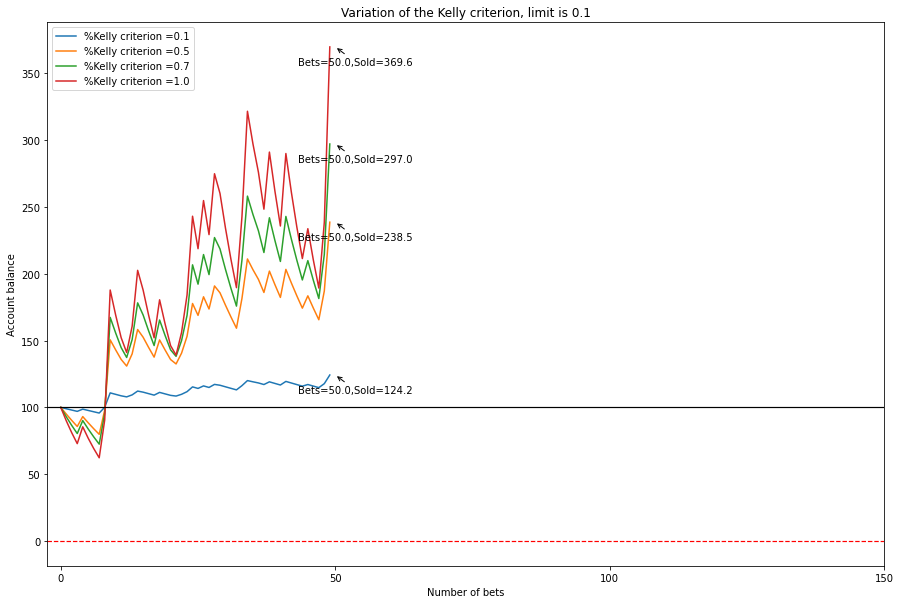

In [ ]:
# Influence of the Kelly criterion (One considers all the matches in the Test dataset)

# Initial balance: 100
# R = 1.1
# The % of the Kelly criterion considered varies, moreover, the Kelly criterion is limited and cannot be more that the "limit" 
# parameter. Here 10%

param_var = [0.1, 0.5, 0.7, 1]
R = 1.1
limit = 0.1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, f, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(R , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="%Kelly criterion ={:.1f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the Kelly criterion, limit is {:.1f}'.format(limit))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# As it has been seen above, the problem with the Kelly criterion is the high values that can be computed leading to 
# potential hugh losses. We try two way of limiting the Kelly criterion: 
# - By considering a fraction of it
# - by limiting its maximum value
# Limiting the Kelly criterion doesn't give better results when a 10% limit is considered
# Limiting the max of the Kelly criterion via the parameter "limit" gives very good results

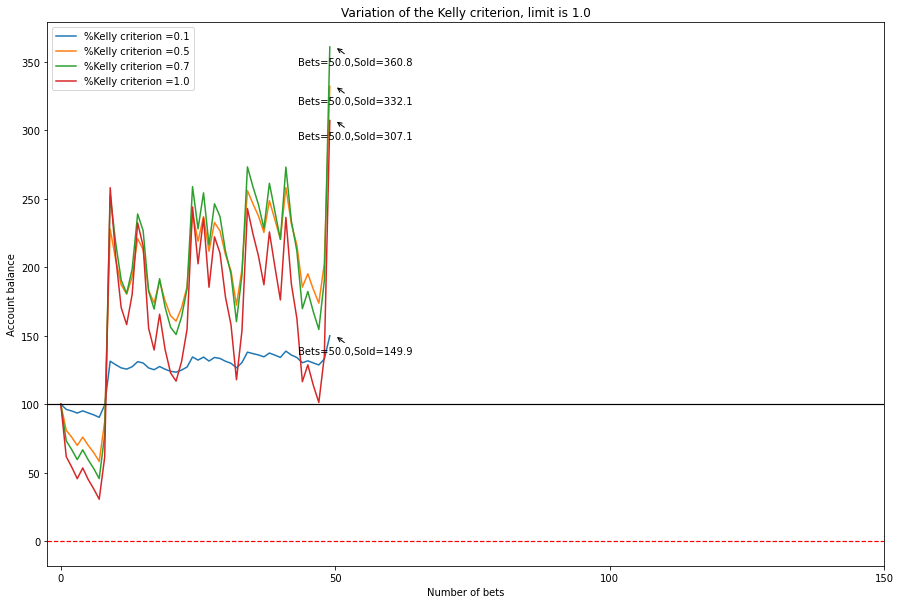

In [ ]:
# Influence of the Kelly criterion (One considers all the matches in the Test dataset)

# Initial balance: 100
# R = 1.1
# The % of the Kelly criterion considered varies, moreover, the Kelly criterion is limited and cannot be more that the "limit" 
# parameter. Here 10%

param_var = [0.1, 0.5, 0.7, 1]
R = 1.1
limit = 1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_R_Kelly(R, f, limit, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Kelly(R , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="%Kelly criterion ={:.1f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the Kelly criterion, limit is {:.1f}'.format(limit))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# As it has been seen above, the problem with the Kelly criterion is the high values that can be computed leading to 
# potential hugh losses. We try two way of limiting the Kelly criterion: 
# - By considering a fraction of it
# - by limiting its maximum value
# Limiting the Kelly criterion gives better results when no max limit is considered

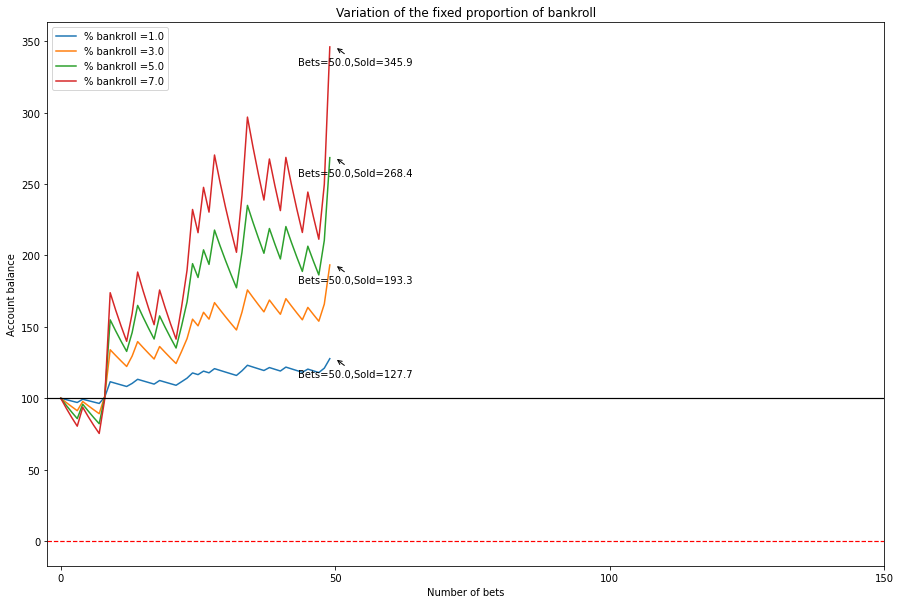

In [ ]:
# Influence of the fixed prop bet (One considers all the matches in the Test dataset)

# Initial balance: 100
# R = 1.1

param_var = [0.01, 0.03, 0.05, 0.07]
initial_bankroll = 100
R = 1.1
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # betting_workflow_R_Fixed_Proportion(R, fixed_prop, initial_bet, prob_computed, odds, winning, match_id)
    gain, match = betting_workflow_R_Fixed_Proportion(R , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="% bankroll ={:.1f}".format(i*100)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,200,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed proportion of bankroll')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# The curve shape is always the same and an homothetic relation exist between curves
# The bet considering the highest fixed proportion of the bankroll ends up with the highest profit

### 2.1 Influence of the probability threshold

In [ ]:
# Influence threshold: (var: 0.5, 0.55,  0.6, 0.65, 0.7, 0.75, 0.8) mise fixe

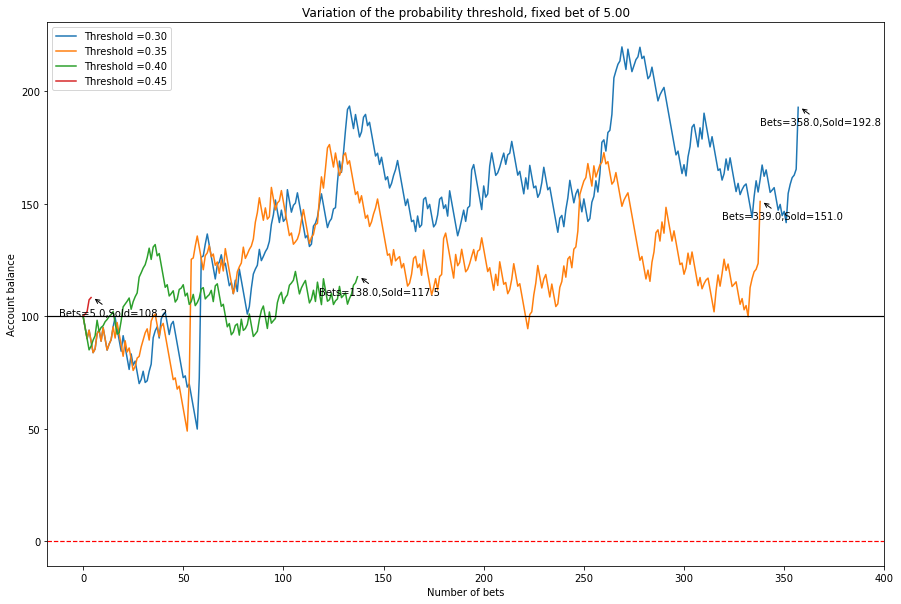

In [ ]:
# Influence of the threshold (One considers all the matches in the Test dataset)

# Initial balance: 100
# Fixed bet: 5
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45]
fixed_bet = 5
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id): 
    gain, match = betting_workflow_Threshold_Fixed(i , fixed_bet, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,450,50))
ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, fixed bet of {:.2f}'.format(fixed_bet))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# High threshold doesn't necessary gives the best result. It reduces the number of bet and the accuracy of 
# the model is not good enough to secure the gain
# Only a high threshold leads to a secure benefit and only few games are considered.
# Under a threshold of 0.3, all games considered for betting

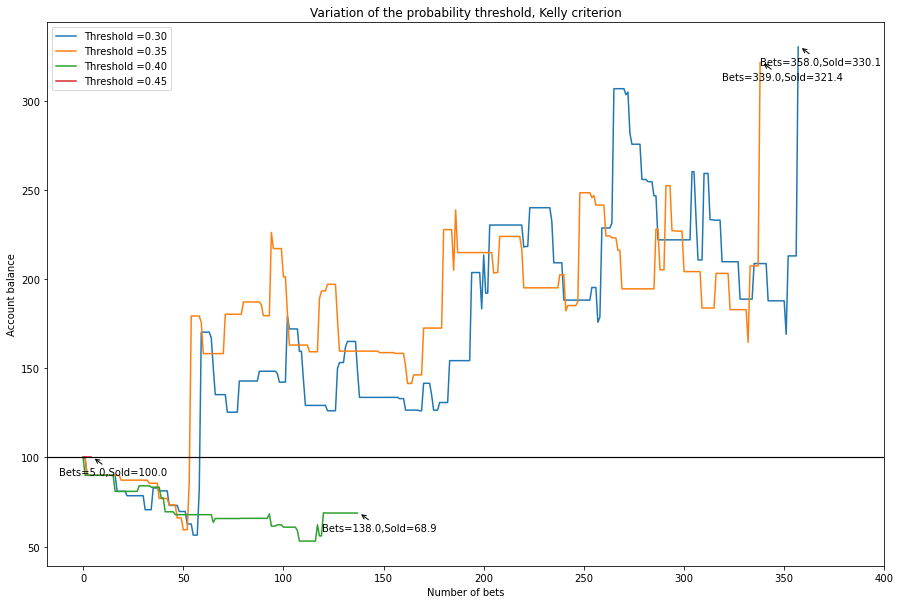

In [ ]:
# Influence of the threshold (One considers all the matches in the Test dataset)

# Initial balance: 100
# Kelly criterion
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45]
f = 1 # % of the kelly criterion considered
limit = 0.1 # limits the Kelly criterion
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Kelly(threshold, f, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Kelly(i , f, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,450,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, Kelly criterion')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Conclusion and remarks
# Good results in terms of benefits.
# A threshold of 0.35 is better than 0.3 but increasing more the threshold doesn't give better results


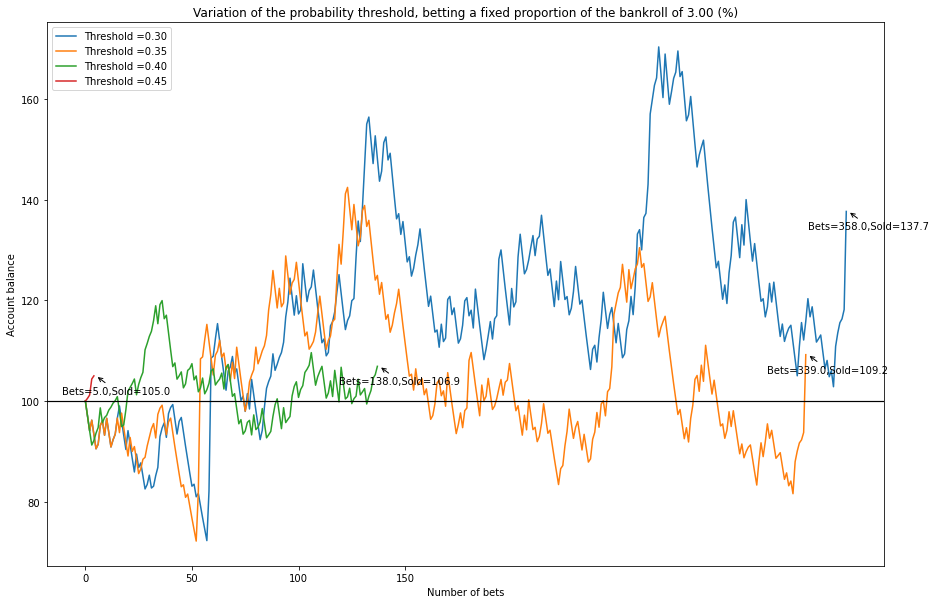

In [ ]:
# Influence of the threshold (One considers all the matches in the Test dataset)

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for the threshold in variable param_var

param_var = [0.3,0.35, 0.4, 0.45]
fixed_prop = 0.03
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Fixed_Proportion(i , fixed_prop, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,170,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the probability threshold, betting a fixed proportion of the bankroll of {:.2f} (%)'.format(fixed_prop*100))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')
    
# Conclusion and remarks
# Same conclusion as previously
    
    

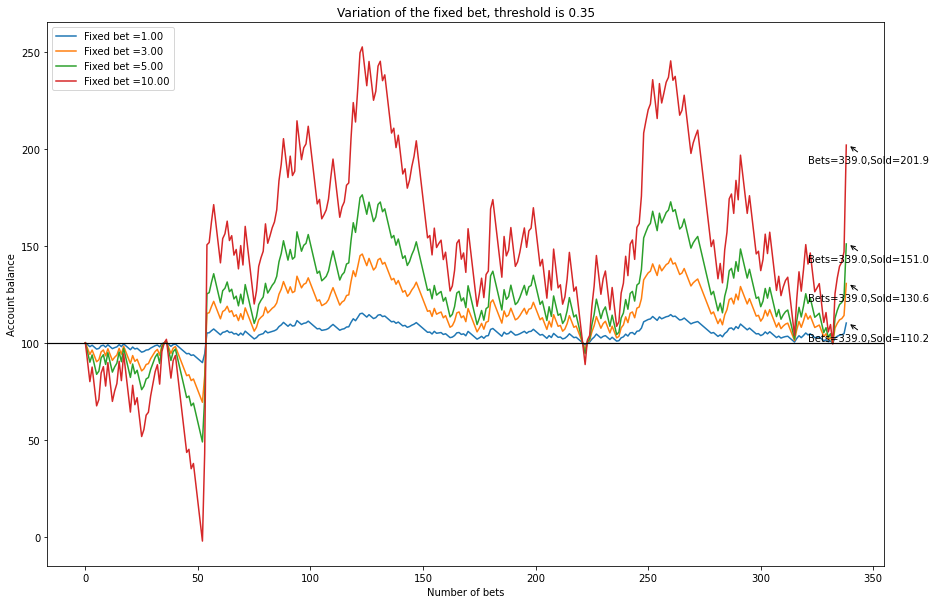

In [ ]:
# Optimum threshold & Var fixed bet 

# Initial balance: 100
# Fixed bet from 1 to 15
# Threshold = 0.7

param_var = [1, 3, 5, 10]
threshold =0.35
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed(threshold, fixed, initial_bet, prob_computed, odds, winning, match_id): 
    gain, match = betting_workflow_Threshold_Fixed(threshold , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Fixed bet ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet, threshold is {:.2f}'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# The curve shape is always the same and an homothetic relation exist between curves (same conclusion as per the R ratio).

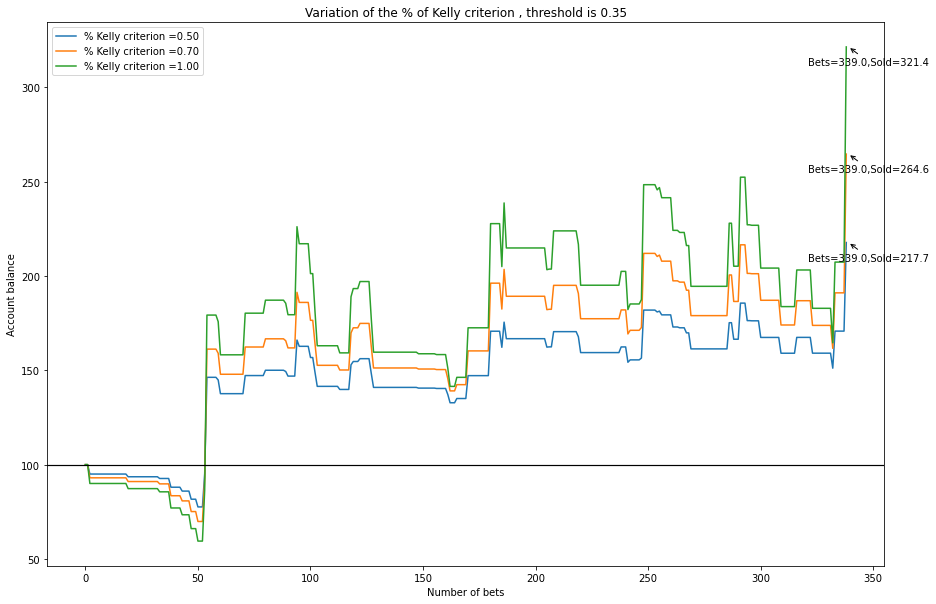

In [ ]:
# Opt threshold & Var f

# Initial balance: 100
# f varies
# Threshold = 0.7

param_var = [0.5, 0.7, 1]
limit = 0.1 # One cannot bet above this bankroll proportion
initial_bankroll = 100
threshold = 0.35

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Kelly(threshold, f, limit, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Kelly(threshold , i, limit, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="% Kelly criterion ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the % of Kelly criterion , threshold is {:.2f}'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Same conclusion as per the R ratio

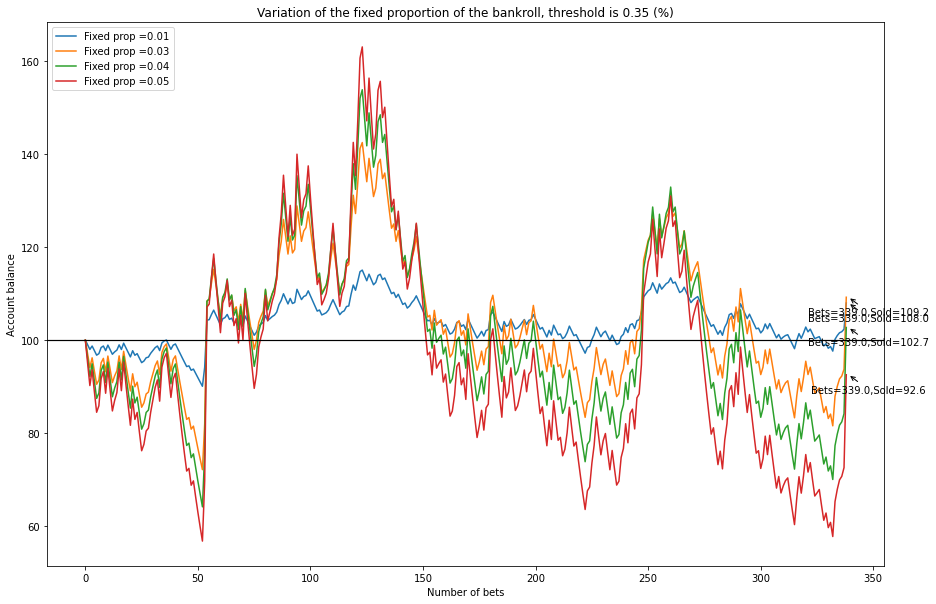

In [ ]:
# Opt threshold & Var fixed prop bet

# Initial balance: 100
# Fixed proportion of the bankroll
# Values considered for the threshold in variable param_var

param_var = [0.01, 0.03, 0.04, 0.05]
initial_bankroll = 100
threshold = 0.35

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #betting_workflow_Threshold_Fixed_Proportion(threshold, fixed_prop, initial_bet, prob_computed, odds, winning, match_id):
    gain, match = betting_workflow_Threshold_Fixed_Proportion(threshold , i, initial_bankroll, df_bet['Match_Prediction_proba'], df_bet['Best_odd'], df_bet['Winning_bet'], df_bet.index)
    ax.plot(range(0,len(gain)), gain, label="Fixed prop ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,400,50))
#ax.axhline(y=0  , xmin=0, xmax=1, color ='red', linestyle='--', linewidth=1.2)
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed proportion of the bankroll, threshold is {:.2f} (%)'.format(threshold))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')

# Increasing the proportion of the bankroll for each bet gives better results but gthe gain from 1% to 3% 
# is higher that from 3% to 5%

In [ ]:
# Conclusion:
# R opt = 1.1, good benefits but no clear tendency, decreasing curves for the last games.
# Threshold opt: 0.7, this leeds to few bets and low benefits.

# Fixed bets seems to provide higher benefits. The Kelly criterion as it is used here and with our model does not provide
# optimized benefits.
# When R is increased the Kelly criterion increases and is no limit is added to the criterion, the bankroll
# converges quickly to zero. The probabilities provided by model and the limited number of matches of the Test dataset
# does not permit the use of the Kelly criterion

## 3. Betting strategies without prediction models

### 3.1 "Sure Bets"

In [ ]:
# A "sure bet" is a bet that guarantee a gain. A lot of websites provide this service of finding such bets. 
# The idea is to bet on all possible outcome checking if the winning bet will provide a gain higher that all the losing bets.
# For a game: if sum(p(i)) = 1 where p(i) is the probability of a possible outcome, 
# when betting on all possible events "i" the amount B*p(i) the total bet is B*sum((p(i)) = B
# if j is the outcome of the match, we win B*p(j)*odd(j) = B (odd(j)=1/p(j) by definition).
# Thus in this theoretical exemple we never lose (and never win).

# For every bookmakers one has: p(A)+p(D)+p(H) = 1 + epsilon, it is always strictly above 1, epsilon > 0
# epsilon is the margin of the bookmaker. Considering the previous approach we are sure to lose money because of this margin,
# by betting B*p(i) on all possible outcomes (B in total) we win an amount strictly inferior to B.

# Here the idea is to find matches where the following consition is found:
# 1/max_n(odd(A)) + 1/max_n(odd(H)) + 1/max_n(odd(D)) < 1
# n is the bookmaker index
# It can only be possible by considering various bookmakers and odd(A), odd(H), odd(D) are from different bookmakers.

In [ ]:
def sure_bet(fixed, initial_bet, df):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    
    for i in range(len(df.index)):
        
        A = [] # odds for event A
        H = [] # odds for event H
        D = [] # odds for event D
        for j in bookmaker_list: # Check for sure bet
            A.append(df.iloc[i, df.columns.get_loc(j+'A')])
            H.append(df.iloc[i, df.columns.get_loc(j+'D')])
            D.append(df.iloc[i, df.columns.get_loc(j+'H')])
        
        if ((1/np.max(A) + 1/np.max(D) + 1/np.max(H))<1): # Check if one has a "sure bet"
            if (df['FTR'].iloc[i] =='A'):
                g = gain[-1] + fixed*(np.max(A)-1) 
            elif (df['FTR'].iloc[i] =='H'):
                g = gain[-1] + fixed*(np.max(H)-1) 
            else:
                g = gain[-1] + fixed*(np.max(D)-1) 
            gain.append(g)    
            match.append(df.index[i])
    return gain , match 


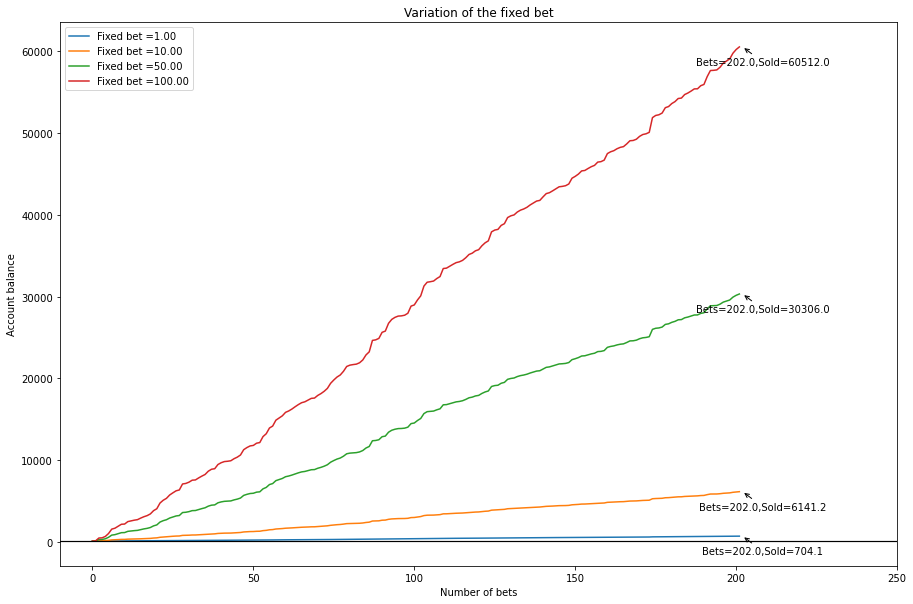

In [ ]:
param_var = [1, 10, 50, 100]
initial_bankroll = 100

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    #sure_bet(fixed, initial_bet, df): 
    gain, match = sure_bet(i, initial_bankroll, df_bet)
    ax.plot(range(0,len(gain)), gain, label="Fixed bet ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,300,50))
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the fixed bet')
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')
# 202 Sure bets have been found for all 4 seasons. By definition the curve never decreases, 
# the highest bets give the highest gain

### 3.2 Bookmakers mistakes

In [ ]:
# Here we only bet on the bookmaker prediction (the minimum odd) 
# And when the difference between:
# the mean of the odds for this predicted event 
# maximum odd of this predicted event (max(min())) is high enough

In [ ]:
def book_bet(fixed, threshold, initial_bet, df):  
    gain = []
    match = []
    gain.append(initial_bet)
    
    bookmaker_list = ['B365', 'LB', 'PS', 'WH', 'VC', 'PSC']
    
    for i in range(len(df.index)):
        Result = []
        O = [] # odds of the predicted event
        for j in bookmaker_list:
            Result.append(df.iloc[i, df.columns.get_loc(j+'R')])
            O.append(df.iloc[i, df.columns.get_loc(j+Result[-1])])
        if all(ind == Result[0] for ind in Result): # We bet only if all the bookmakers predict the same result
            if (np.max(O)-np.mean(O) > threshold): 
                if (df['FTR'].iloc[i] == Result[-1]):
                    g = gain[-1] + fixed*(np.max(O)-1) 
                else:
                    g = gain[-1] - fixed
                gain.append(g)    
                match.append(df.index[i])
    return gain , match 

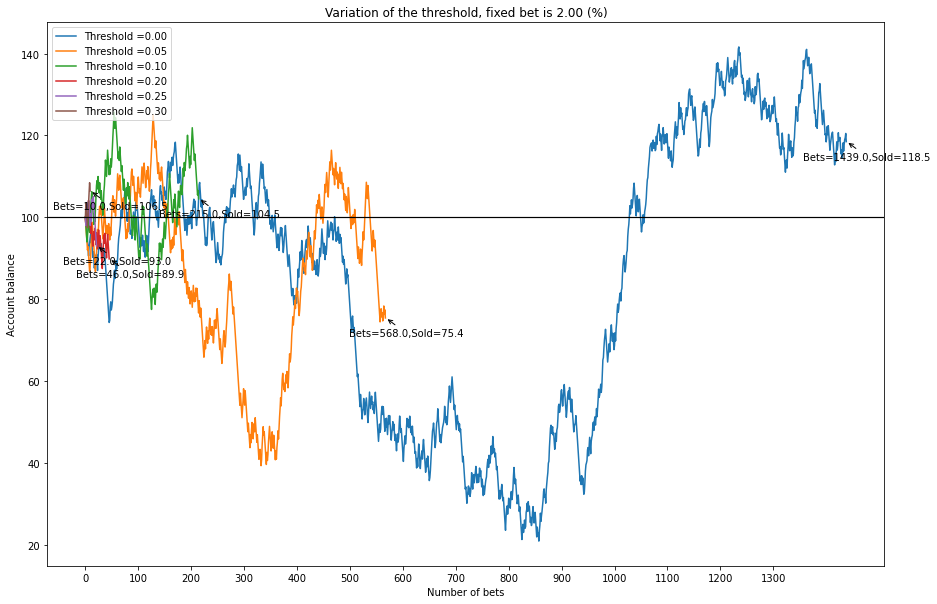

In [ ]:
param_var = [0, 0.05, 0.1, 0.2, 0.25, 0.3]
initial_bankroll = 100
fixed = 2
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111) 

for i in param_var:
    # book_bet(fixed, threshold, initial_bet, df): 
    gain, match = book_bet(fixed, i, initial_bankroll, df_bookmakers)
    ax.plot(range(0,len(gain)), gain, label="Threshold ={:.2f}".format(i)) 
    ax.annotate("Bets={0:.1f},Sold={1:.1f}".format(len(gain),gain[-1]), xy=(len(gain), gain[-1]), xytext=(20, -20), textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
ax.set_xticks(range(0,1400,100))
ax.axhline(y=100, xmin=0, xmax=1, color ='black', linestyle='-', linewidth=1.2)
ax.set_title('Variation of the threshold, fixed bet is {:.2f} (%)'.format(fixed))
ax.set_ylabel('Account balance')
ax.set_xlabel('Number of bets')
ax.legend(loc='upper left')
# After 4 seasons on betting a fixed bet on the minimum odd and on the best offer, does not give satisfying results:
# no clear tendancy and no gain except for a zero threshold but there is no guarantee that this positive 
# bankroll stays positive

# Conclusion

In [ ]:
'''A limited Kelly criterion combined with the decision ratio previously defined gives satisfying results'''

'A limited Kelly criterion combined with the decision ratio previously defined gives satisfying results'

In [ ]:
# CSV save
df_bet.to_csv('df_betting_strategy.csv')